## Network Flow: Edmonds-Karp

In [3]:
# Install dependencies
!pip install -r requirements.txt --quiet

In [4]:
import otter
assert (
    otter.__version__ >= "4.4.1"
), "Please reinstall the requirements and restart your kernel."

import numpy as np
import networkx as nx
import queue
import typing
import tqdm
import pickle
from collections import deque

grader = otter.Notebook("edmonds_karp.ipynb")
rng_seed = 42

In [5]:
prng1 = np.random.default_rng(seed=rng_seed)

# Load test cases
file_path = "generated_testcases.pkl"

# Load the variables from the pickle file
with open(file_path, "rb") as file:
    loaded_data = pickle.load(file)
file.close()
inputs, outputs = loaded_data

In [6]:
def rand_graph(size=None):
    """
    args:
        size:int = number of vertices in randomly generated graph.
    return:
        nx.DiGraph that represents the randomly generated directed graph.
    """
    if not size:
        g = nx.gnp_random_graph(prng1.integers(16, 64), 0.25, seed=rng_seed, directed=True)
    else:
        g = nx.gnp_random_graph(size, 0.25, seed=rng_seed, directed=True)
        
    for u, v in g.edges:
        g.edges[u, v]["capacity"] = prng1.integers(0, 50)
        g.edges[u, v]["flow"] = 0
    return g

Here, we will implement one well-defined implementation of Ford–Fulkerson algorithm: Edmonds–Karp algorithm.

What Ford–Fulkerson does can be summarised as 3 steps:

* Find an augmenting path in the graph
* Construct the residual graph by augmenting the path based on the original graph and augmenting path.
* Do this until no augmenting path can be found.

Ford-Fulkerson is not well-defined because there could be multiple ways of doing step 0: by DFS, by A* search, by some RL model that takes 200 RTX A6000 to train, or by magic......


If we use BFS to find the augmenting path, this algorithm is called Edmonds–Karp algorithm which is what we will implement today.

> Fun fact: Edmonds–Karp algorithm was first introduced by Soviet mathematician Yefim Dinitz/Dinic, yet Dinic's Algorithm is the name of a more complex and efficient algorithm for Network Flow problems (out of scope for CS170).

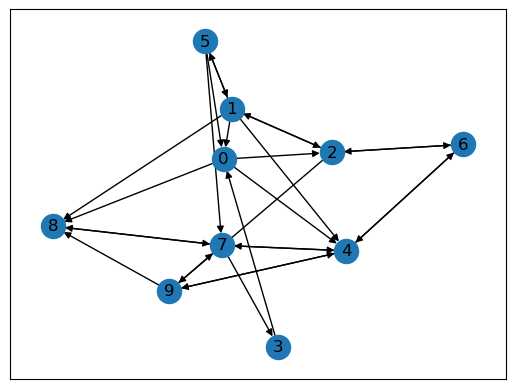

In [5]:
nx.draw_networkx(rand_graph(10))

### Augmenting Path
First, you will implement the BFS portion of Edmonds–Karp algorithm.
Given a graph and `s` and `t` vertices, find a augmenting path (a list of vertices from `s` to `t` **including** `s` and `t`) with BFS. If there's no path, return None.

### Networkx tricks

There are some `networkx` tricks you might want to use below to make your life way easier:

To access flow from edge `(u, v)`, do `g.edges[u, v]["flow"]`; sub `flow` for `capacity` for capacity.

To access outgoing edges from `c` like adjacency list, do `g.edges(c)`. Note the returned type is an iterable of vertex tuples, so you should do something like:

```
for u, v in g.edges(c):
    e = g.edges[u, v]
    print(e["flow"])
```
    
To update some edge $(u, v)$ to have flow of `f`, we can do either `g.add_edge(u, v, flow=f, capacity=c)` or `g.edges[u, v]["flow"] = f`, where `c` is the capacity of the edge - make sure you don't change edge capacities!

For the purpose of this coding HW, instead of decreasing `g.edges[u, v]["capacity"]` and check if it's still greater than zero each time you find or augment a path, please increase `g.edges[u, v]["flow"]` and check if it's still greater than `g.edges[u, v]["capacity"]`.

While `g.edges[u, v]` looks like adjacency matrix it is not - if `(u, v)` doesn't exist there would be `KeyError`.
Later, when implementing `edmonds_karp()`, you can use `nx.algorithms.flow.build_residual_network` to prevent `KeyError`s. `nx.algorithms.flow.build_residual_network` takes in an input graph and a key variable (for this assignment, the key will always be "capacity"), and returns a graph with 0-capacity edges placed wherever there is no edge in the input graph. For more information, see the [documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.build_residual_network.html).

### Q1) Find Augmenting Path

**Task**
* Given a graph represented via a networkx graph, find the BFS augmenting path that has $>0$ flow available.
* Return a list of length equal to the number of nodes where the $i$-th element in this list is the $i$-th node on the $s$-$t$ path. The first and last nodes should be $s$ and $t$ respectively.
* If no such path is available return an empty list.

We recommend you use a `deque` for your BFS queue. You can read more about `deque` [here](https://docs.python.org/3/library/collections.html#collections.deque).

_Points:_ 3

In [9]:
def bfs_augmenting_path(g, s, t):
    """
    args:
        g:nx.DiGraph = directed network flow graph
        s:int = source node s
        t:int = sink node t
    return:
        List[int] representing the augmenting path that BFS finds. First 
            and last nodes should be s and t respectively. Return [] if 
            path doesn't exist. Ex: [s, a, b, t] if (s, a), (a, b), (b, t)
            is the shortest length augmenting path.
    """
    queue = deque([(s, [s])])
    visited = set()
    
    while queue:
        u, path = queue.popleft()
        visited.add(u)
        if u == t:
            return path
        for w,v in g.edges(u):
            if v not in visited and g.edges[u, v]["flow"] < g.edges[u, v]["capacity"]:
                new_path = path + [v]
                queue.append((v, new_path))
    return []

In [8]:
grader.check("q1")

Running Test 1: 100%|██████████| 100/100 [00:00<00:00, 2780.32it/s]


q1 results: All test cases passed!

### Q2) Edmonds-Karp

Now, implement Edmonds-Karp with the functions you made above:

1. Find an augmenting path in the graph (with `bfs_augmenting_path`)
2. Construct the residual graph by augmenting the path based on the original graph and augmenting path (with `augment` described below)
3. Do this until no augmenting path can be found.

Return the capacity and the final residual graph. The autograder will only check capacity, but having access to the graph may come in handy later. Do not modify G (you can do it by making a copy of G by invoking `g.copy()`).

> *Hint:* You may find it helpful to fill in the helper function `augment`: given an  s-t path, determine the maximum amount of flow that can be pushed through this path (this is bottlenecked by the smallest capacity edge the augmenting path). Then, augment the path by increasing flow for u-v and do the opposite for v-u. Finally, return the capacity of the flow you augmented.

In [10]:
def edmonds_karp(g, s, t):
    """
    args:
        g:nx.DiGraph = directed network flow graph
        s:int = source node s
        t:int = sink node t
    return:
        Tuple(int, nx.DiGraph) where the first value represents the max flow that
            was successfully pushed, and the second value represents the graph
            where the flow values along each edge represents the flow pushed through
            that edge.
    """
    graph = nx.algorithms.flow.build_residual_network(g.copy(), "capacity")
    nx.set_edge_attributes(graph, 0, "flow")
    flow = 0
    
    def augment(g, path):
        flows = []
        for i in range(len(path)-1):
            # current = g.edges[path[i],path[i+1]]["capacity"] - g.edges[path[i],path[i+1]]["flow"]
            flows.append(g.edges[path[i],path[i+1]]["capacity"] - g.edges[path[i],path[i+1]]["flow"])
        bottle_neck = min(flows)
        
        for i in range(len(path)-1):
            g.edges[path[i],path[i+1]]["flow"] += bottle_neck
        return bottle_neck
    
    # Use the augment function to compute the max flow
    while path := bfs_augmenting_path(g,s,t):
        flow += augment(g, path)
    return flow, graph

In [11]:
grader.check("q2")

Running Test 2: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


q2 results: All test cases passed!

### Q3) Min-Cut

Recall that the dual of the Max-Flow problem is the Min-Cut problem. In the Min-Cut problem, we are given a network, and we wish to find a vertex cut of this graph, $(S, T)$ where $S \cup T = V,$ $S \cap T = \emptyset,$ $s \in S, t \in T$ such that the sum of the capacities of the edges spanning this cut (going from $S$ to $T$) is minimized. 

Here, we'll see how, given a solution to the max-flow problem on a graph, we can easily find the min cut. Implement `find_min_cut` to find the minimum S-T cut of this graph (which also yields the edges with saturated flow). Make sure to return all the vertices that belong to the $S$ partition of the cut.

In [ ]:
def find_min_cut(g, s, t):
    """
    args:
        g:nx.DiGraph = directed network flow graph
        s:int = source node s
        t:int = sink node t
    return:
        Set(int) that contains all vertices in the min cut of g that includes s.
    """
    vertex_cut_s = set([s])
    flow, graph = edmonds_karp(g, s, t)
    visited = set()
    q = deque([s])
    while q:
        u = q.popleft()
        vertex_cut_s.add(u)
        visited.add(u)
        for w,v in g.edges(u):
            if v not in visited and g.edges[u, v]["flow"] < g.edges[u, v]["capacity"]:
                q.append(v)
    
    return vertex_cut_s

In [ ]:
grader.check("q3")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [ ]:
grader.export(pdf=False, force_save=True, run_tests=True)